# Multi-Portfolio Risk Analysis Framework (v2)

This notebook unifies the specific portfolio definitions, data acquisition, risk modeling, and multi-portfolio comparison into a single workflow.

## Objectives

1.  **Define Universes**: Specify 10 distinct equity portfolios (Market, Sector, Global).
2.  **Data Acquisition**: Efficiently download historical data for all unique tickers.
3.  **Risk Modeling**: Apply Minimum Variance Optimization, EWMA Volatility Forecasting, and Stress Testing (COVID-19).
4.  **Comparison**: Aggregate metrics to test hypotheses about diversification and robustness.

## Directory Structure

- **Notebook**: `v2/multi_portfolio_risk_v2.ipynb`
- **Data Storage**: `v2/data/P{x}/` (e.g., `v2/data/P1/clean_returns.csv`)


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import warnings

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Setup Directories
# Notebook is in v2/, so data will be in ./data relative to notebook
BASE_DIR = "data" 
os.makedirs(BASE_DIR, exist_ok=True)
print(f"Working Directory: {os.getcwd()}")
print(f"Data Directory: {os.path.abspath(BASE_DIR)}")

Working Directory: e:\risk-dash\v2
Data Directory: e:\risk-dash\v2\data


## 1. Portfolio Universe Definition

We define 10 distinct portfolios (P1-P10) ranging from broad market indices to concentrated sector bets and global allocations.


In [3]:
# Define Stock Universes
TIER_1_TOP_50 = [
    "AAPL", "MSFT", "AMZN", "NVDA", "GOOGL", "GOOG", "META", "TSLA", "BRK.B", "LLY",
    "AVGO", "JPM", "V", "XOM", "UNH", "MA", "PG", "JNJ", "HD", "COST",
    "MRK", "ABBV", "CVX", "CRM", "BAC", "WMT", "AMD", "PEP", "NFLX", "KO",
    "LIN", "ADBE", "DIS", "TMO", "MCD", "CSCO", "ACN", "ABT", "DHR", "INTU",
    "WFC", "QCOM", "TXN", "GE", "VZ", "AMGN", "INTC", "IBM", "PM", "CAT"
]

TIER_2_NEXT_50 = [
    "SPGI", "HON", "RTX", "UNP", "LOW", "BKNG", "AMAT", "GS", "COP", "PFE",
    "BLK", "T", "BA", "ISRG", "UBER", "NEE", "NOW", "SYK", "NKE", "LRCX",
    "MS", "ETN", "C", "AXP", "ELV", "DE", "LMT", "MDT", "TJX", "VRTX",
    "PGR", "SBUX", "MMC", "MU", "SCHW", "ADP", "BSX", "ADI", "GILD", "CB",
    "CI", "MDLZ", "FI", "PLD", "TMUS", "REGN", "BMY", "CVS", "ZTS", "PANW"
]

# TIER 3 & 4 (Simplified for brevity, using representative mid-caps from S&P 500)
TIER_3_MID_50 = [
    "APH", "CL", "KLAC", "SNPS", "MO", "CDNS", "EOG", "SHW", "ITW", "CMCSA",
    "SO", "ICE", "DUK", "SLB", "TGT", "CSX", "MAR", "BDX", "NOC", "PH",
    "MCK", "CME", "ORCL", "PYPL", "USB", "HCA", "EMR", "FCX", "NXPI", "AON",
    "FDX", "ROP", "MCO", "PSX", "MPC", "GD", "SRE", "AEP", "ORLY", "ADSK",
    "OXY", "D", "WELL", "AZO", "MSI", "AJG", "COF", "TRV", "HLT", "CARR"
]

# Proxies for specific strategies
NASDAQ_PROXY = ["AAPL", "MSFT", "AMZN", "NVDA", "META", "GOOGL", "TSLA", "AVGO", "ADBE", "PEP", "COST", "CSCO", "TMUS", "CMCSA", "INTC", "QCOM", "TXN", "AMGN", "HON", "INTU", "AMAT", "BKNG", "SBUX", "MDLZ", "ISRG", "GILD", "VRTX", "ADP", "LRCX", "ADI", "REGN", "MU", "PANW", "SNPS", "KDP", "KLAC", "CDNS", "CHTR", "MAR", "CSX", "MELI", "MNST", "NXPI", "ORLY", "CTAS", "FTNT", "WDAY", "ODFL", "PCAR", "MCHP", "CPRT", "ROST", "PAYX", "IDXX", "AEP", "KHC", "FAST", "EXC", "GEHC", "BIIB", "DXCM", "XEL", "VRSK", "CSGP", "WBD", "TEAM", "GFS", "FANG", "DLTR", "EBAY", "ILMN", "SIRI", "ANSS", "WBA", "SPLK", "ALGN", "ZM", "LCID", "ENPH", "JD", "BIDU", "PDD", "NTES", "TCOM", "SGEN", "ZS", "CRWD", "DDOG", "MRVL"]
TECH_SECTOR = ["AAPL", "MSFT", "NVDA", "AVGO", "ADBE", "CSCO", "ACN", "CRM", "ORCL", "AMD", "QCOM", "INTC", "TXN", "IBM", "INTU", "AMAT", "NOW", "LRCX", "ADI", "MU", "PANW", "SNPS", "KLAC", "CDNS", "APH", "NXPI", "ADSK", "MSI", "MCHP", "TEL", "IT", "GLW", "HPE", "KEYS", "FTNT", "ANSS", "CDW", "BR", "TRMB", "TDY", "TYL", "PTC", "WDC", "STX", "NTAP", "FFIV", "JNPR", "GEN", "AKAM"]
DEFENSIVE_SECTOR = ["PG", "JNJ", "KO", "PEP", "MRK", "ABBV", "COST", "WMT", "MCD", "UNH", "LLY", "PFE", "PM", "MO", "CL", "T", "VZ", "SO", "DUK", "NEE", "AEP", "D", "ED", "XEL", "PEG", "WEC", "ES", "DTE", "EIX", "PPL", "CMS", "AEE", "FE", "LNT", "ATO", "EVRG", "NI", "PNW", "AWK", "K", "GIS", "KMB", "SJM", "CAG", "CPB", "HSY", "MKC", "CHD"]
EAFE_PROXY = ["NSRGY", "LVMUY", "ASML", "NVO", "RHHBY", "SHEL", "AZN", "TM", "SAP", "HSBC", "SIEGY", "IDEXY", "SONY", "DEO", "TOT", "BTI", "UL", "SNY", "GSK", "BP", "DDAIF", "BMWYY", "VOW3.DE", "BBL", "WBK", "PCRFY"]

# Portfolio Definitions Dictionary
PORTFOLIOS = {
    "P1": {"name": "S&P 500 Large-Cap", "universe": TIER_1_TOP_50 + TIER_2_NEXT_50 + TIER_3_MID_50}, # Using top ~150 as proxy for 500
    "P2": {"name": "S&P 500 Concentrated", "universe": TIER_1_TOP_50},
    "P3": {"name": "S&P 500 Mid-Range", "universe": TIER_2_NEXT_50 + TIER_3_MID_50},
    "P4": {"name": "Russell 1000 Proxy", "universe": TIER_1_TOP_50 + TIER_2_NEXT_50 + TIER_3_MID_50}, # Same as P1 for this data set
    "P5": {"name": "NASDAQ-100 Tech-Heavy", "universe": [t for t in NASDAQ_PROXY if t in TIER_1_TOP_50 + TIER_2_NEXT_50 + TIER_3_MID_50 + TECH_SECTOR]}, # Limit to known tickers
    "P6": {"name": "Sector: Technology", "universe": TECH_SECTOR},
    "P7": {"name": "Sector: Defensive", "universe": DEFENSIVE_SECTOR},
    "P8": {"name": "Balanced Sector", "universe": list(set(TECH_SECTOR[:15] + DEFENSIVE_SECTOR[:15] + ["XOM", "CVX", "JPM", "BAC"]))},
    "P9": {"name": "International Developed", "universe": EAFE_PROXY},
    "P10": {"name": "Global All-Weather", "universe": list(set(TIER_1_TOP_50[:20] + EAFE_PROXY[:10] + DEFENSIVE_SECTOR[:10]))}
}

print("Portfolio Definitions Loaded.")

Portfolio Definitions Loaded.


## 2. Data Acquisition

We download a "Master List" of all unique tickers to avoid redundant API calls, then distribute data to specific portfolio folders.


In [7]:
def download_and_process_data():
    # 1. Gather all unique tickers
    all_tickers = set()
    for p in PORTFOLIOS.values():
        all_tickers.update(p['universe'])
    
    unique_tickers = list(all_tickers)
    print(f"Total unique tickers to download: {len(unique_tickers)}")
    
    # 2. Download Master Data
    master_file = "data/raw_prices_master.csv"
    
    if os.path.exists(master_file):
        print("Master data file already exists. Loading local data...")
        prices = pd.read_csv(master_file, index_col=0, parse_dates=True)
    else:
        print("Downloading from Yahoo Finance...")
        # Batch download in chunks to avoid URL length issues
        chunk_size = 50
        chunks = [unique_tickers[i:i + chunk_size] for i in range(0, len(unique_tickers), chunk_size)]
        
        all_data = []
        for i, chunk in enumerate(chunks):
            print(f"Downloading chunk {i+1}/{len(chunks)}...")
            try:
                # auto_adjust=False ensures we get 'Adj Close'
                data = yf.download(chunk, start="2018-01-01", end=pd.Timestamp.today().strftime('%Y-%m-%d'), progress=False, auto_adjust=False)
                
                if 'Adj Close' in data.columns:
                    adj_close = data['Adj Close']
                else:
                    # Fallback if only 'Close' exists (e.g. auto_adjusted already)
                    print(f"  Warning: 'Adj Close' not found in chunk {i+1}, using 'Close'")
                    adj_close = data['Close'] if 'Close' in data.columns else data
                    
                all_data.append(adj_close)
                
            except Exception as e:
                print(f"Error downloading chunk {i}: {e}")
        
        if all_data:
            prices = pd.concat(all_data, axis=1)
            # Remove duplicate columns if any
            prices = prices.loc[:, ~prices.columns.duplicated()]
            prices.to_csv(master_file)
            print("Master download complete.")
        else:
            raise ValueError("No data downloaded")

    # 3. Process Per-Portfolio Data
    for pid, config in PORTFOLIOS.items():
        print(f"Processing {pid}: {config['name']}...")
        p_dir = f"data/{pid}"
        os.makedirs(p_dir, exist_ok=True)
        
        # Filter columns
        # Ensure we only pick columns that exist in prices
        valid_tickers = [t for t in config['universe'] if t in prices.columns]
        p_prices = prices[valid_tickers].copy()
        
        # Clean Data (Drop columns with too many NaNs, fill remaining)
        # Drop tickers with >10% missing data
        p_prices = p_prices.dropna(axis=1, thresh=int(len(p_prices)*0.9)) 
        p_prices = p_prices.ffill().dropna()
        
        if p_prices.empty:
            print(f"  Warning: No valid data for {pid} (Empty DataFrame after cleaning)")
            continue
            
        # Calculate Returns
        p_returns = p_prices.pct_change().dropna()
        
        if p_returns.empty:
             print(f"  Warning: Returns empty for {pid}")
             continue

        # Save
        p_prices.to_csv(f"{p_dir}/clean_prices.csv")
        p_returns.to_csv(f"{p_dir}/clean_returns.csv")
        print(f"  Saved {len(p_returns.columns)} assets.")
        
    print("\nData processing complete.") # Added confirmation message

# Run Data Pipeline
download_and_process_data()

Total unique tickers to download: 223


$BBL: possibly delisted; no timezone found
$BRK.B: possibly delisted; no timezone found
$WBK: possibly delisted; no timezone found

3 Failed downloads:
['BBL', 'BRK.B', 'WBK']: possibly delisted; no timezone found


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
$FI: possibly delisted; no timezone found
$ANSS: possibly delisted; no timezone found

2 Failed downloads:
['FI', 'ANSS']: possibly delisted; no timezone found


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
$BMWYY: possibly delisted; no timezone found

1 Failed download:
['BMWYY']: possibly delisted; no timezone found


$JNPR: possibly delisted; no timezone found
$PCRFY: possibly delisted; no timezone found

2 Failed downloads:
['JNPR', 'PCRFY']: possibly delisted; no timezone found


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
$DDAIF: possibly delisted; no timezone found

1 Failed download:
['DDAIF']: possibly delisted; no timezone found


Master download complete.
Processing P1: S&P 500 Large-Cap...
  Saved 146 assets.
Processing P2: S&P 500 Concentrated...
  Saved 49 assets.
Processing P3: S&P 500 Mid-Range...
  Saved 97 assets.
Processing P4: Russell 1000 Proxy...
  Saved 146 assets.
Processing P5: NASDAQ-100 Tech-Heavy...
  Saved 43 assets.
Processing P6: Sector: Technology...
  Saved 47 assets.
Processing P7: Sector: Defensive...
  Saved 48 assets.
Processing P8: Balanced Sector...
  Saved 34 assets.
Processing P9: International Developed...
  Saved 20 assets.
Processing P10: Global All-Weather...
  Saved 35 assets.


## 3. Analysis Library

Core functions for data loading, optimization, and risk metrics. This modular approach allows us to iterate through all portfolios easily.


In [8]:
def load_portfolio_data(pid):
    """Load clean returns for a specific portfolio"""
    path = f"data/{pid}/clean_returns.csv"
    if not os.path.exists(path):
        return None
    return pd.read_csv(path, index_col=0, parse_dates=True)

def optimize_portfolio(returns):
    """Stage 1: Minimum Variance Optimization"""
    cov_matrix = returns.cov() * 252
    
    # Regularize specific to numerical stability
    eigvals = np.linalg.eigvalsh(cov_matrix.values)
    if eigvals.min() < 1e-8:
        cov_matrix += np.eye(len(cov_matrix)) * 1e-8
        
    n_stocks = len(returns.columns)
    x0 = np.ones(n_stocks) / n_stocks
    
    # Constraints: Sum = 1, bounds (0, 10% max allocation per stock for diversification enforcement)
    # Using 5% as per original plan unless portfolio is small
    max_weight = 0.05 if n_stocks > 25 else 0.10
    
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]
    bounds = tuple((0.0, max_weight) for _ in range(n_stocks))
    
    def port_vol(w):
        return np.sqrt(w.T @ cov_matrix.values @ w)
    
    result = minimize(
        port_vol, x0, 
        method='SLSQP', bounds=bounds, constraints=constraints,
        options={'maxiter': 1000, 'ftol': 1e-8}
    )
    
    return result.x if result.success else x0

def calculate_metrics(returns, weights):
    """Calculate volatility, EWMA, and Stress Tests"""
    # 1. Basic Annual Volatility
    cov_ann = returns.cov() * 252
    port_vol = np.sqrt(weights.T @ cov_ann.values @ weights) * 100
    
    # Benchmark (Equal Weight)
    ew_weights = np.ones(len(weights)) / len(weights)
    ew_vol = np.sqrt(ew_weights.T @ cov_ann.values @ ew_weights) * 100
    
    # 2. EWMA Volatility
    # Use pandas ewm for volatility vector, combine with static correlation
    ewm_vol_series = returns.ewm(alpha=0.06, adjust=False).std() # Lambda = 0.94 -> alpha = 0.06
    latest_vol_vector = ewm_vol_series.iloc[-1].values * np.sqrt(252)
    
    corr_matrix = returns.corr().values
    
    # Covariance = Outer(Vol) * Correlation
    # We do (Vol * Vol_T) * Corr
    cov_ewma = np.outer(latest_vol_vector, latest_vol_vector) * corr_matrix
    port_ewma_var = weights.T @ cov_ewma @ weights
    port_ewma_vol = np.sqrt(port_ewma_var) * 100
    
    # 3. VaR 99% (Historical)
    port_returns = returns @ weights
    var_99 = np.percentile(port_returns, 1) * -1
    
    # 4. Stress Test: COVID (Feb-Mar 2020)
    covid_start, covid_end = '2020-02-19', '2020-03-23'
    if covid_start in port_returns.index and covid_end in port_returns.index:
        covid_ret = port_returns.loc[covid_start:covid_end]
        covid_loss = (1 + covid_ret).cumprod().iloc[-1] - 1
        # Max Daily VaR during covid
        covid_var_99 = np.percentile(covid_ret, 1) * -1
    else:
        covid_var_99 = np.nan
        
    # 5. Diversification Ratio
    # Weighted avg vol / Port Vol
    w_avg_vol = weights @ np.sqrt(np.diag(cov_ann.values))
    div_ratio = w_avg_vol / (port_vol/100) # port_vol is %, w_avg_vol is raw
    
    # 6. Concentration (Eff N)
    risk_contrib = (cov_ann.values @ weights) * weights / (port_vol/100)**2
    # risk_contrib sum should be 1. Normalize just in case
    risk_contrib = risk_contrib / risk_contrib.sum()
    hhi = (risk_contrib**2).sum()
    eff_n = 1/hhi if hhi > 0 else 0

    return {
        'n_stocks': len(weights),
        'mv_vol': port_vol,
        'ew_vol': ew_vol,
        'vol_reduction': (ew_vol - port_vol)/ew_vol * 100,
        'current_ewma_vol': port_ewma_vol,
        'hist_var_99': var_99 * 100,
        'covid_var_99': covid_var_99 * 100,
        'div_ratio': div_ratio,
        'eff_n': eff_n
    }

## 4. Execution Loop

Run the analysis pipeline for all 10 portfolios and aggregate the results.


In [9]:
results_list = []

print("Starting Multi-Portfolio Analysis...")

# Sort pids P1..P10
pids = sorted(PORTFOLIOS.keys(), key=lambda x: int(x[1:]))

for pid in pids:
    p_name = PORTFOLIOS[pid]['name']
    
    # Load
    returns = load_portfolio_data(pid)
    if returns is None:
        print(f"Skipping {pid} (No Data)")
        continue
        
    print(f"Analyzing {pid}: {p_name} ({len(returns.columns)} assets)...")
    
    # Optimize
    weights = optimize_portfolio(returns)
    
    # Calc Metrics
    metrics = calculate_metrics(returns, weights)
    
    # Store
    row = {'id': pid, 'Name': p_name, 'Category': 'Market' if int(pid[1:])<=4 else ('Sector' if int(pid[1:])<=8 else 'China/Global')}
    row.update(metrics)
    results_list.append(row)

# Create DataFrame
df_results = pd.DataFrame(results_list)
print("\nAnalysis Complete.")

Starting Multi-Portfolio Analysis...
Analyzing P1: S&P 500 Large-Cap (146 assets)...
Analyzing P2: S&P 500 Concentrated (49 assets)...
Analyzing P3: S&P 500 Mid-Range (97 assets)...
Analyzing P4: Russell 1000 Proxy (146 assets)...
Analyzing P5: NASDAQ-100 Tech-Heavy (43 assets)...
Analyzing P6: Sector: Technology (47 assets)...
Analyzing P7: Sector: Defensive (48 assets)...
Analyzing P8: Balanced Sector (34 assets)...
Analyzing P9: International Developed (20 assets)...
Analyzing P10: Global All-Weather (35 assets)...

Analysis Complete.


## 5. Comparison & Reporting

Generate the comparison table and visualize key risk metrics across portfolios.


### Master Comparison Table


,id,Name,n_stocks,mv_vol,ew_vol,vol_reduction,current_ewma_vol,covid_var_99,eff_n
0,P1,S&P 500 Large-Cap,146,14.010408,19.028877,26.372913,12.912889,8.025216,24.335264
1,P2,S&P 500 Concentrated,49,15.181040,19.240708,21.099366,13.292174,8.693351,21.883917
2,P3,S&P 500 Mid-Range,97,14.736415,19.320527,23.726641,13.604742,8.868206,22.075491
3,P4,Russell 1000 Proxy,146,14.010408,19.028877,26.372913,12.912889,8.025216,24.335264
4,P5,NASDAQ-100 Tech-Heavy,43,17.054018,22.820650,25.269360,14.182012,9.621809,20.134456
5,P6,Sector: Technology,47,20.407367,25.246301,19.166905,17.867562,9.551409,21.306018
6,P7,Sector: Defensive,48,14.213186,16.005591,11.198618,12.488614,7.244620,22.560785
7,P8,Balanced Sector,34,15.353944,18.376993,16.450187,14.324105,9.526725,21.673008
8,P9,International Developed,20,14.989469,17.089029,12.286008,14.200152,8.370074,11.989635
9,P10,Global All-Weather,35,14.482171,17.746431,18.393899,13.450122,8.738228,21.516526


Charts saved to data/comparison_charts.png


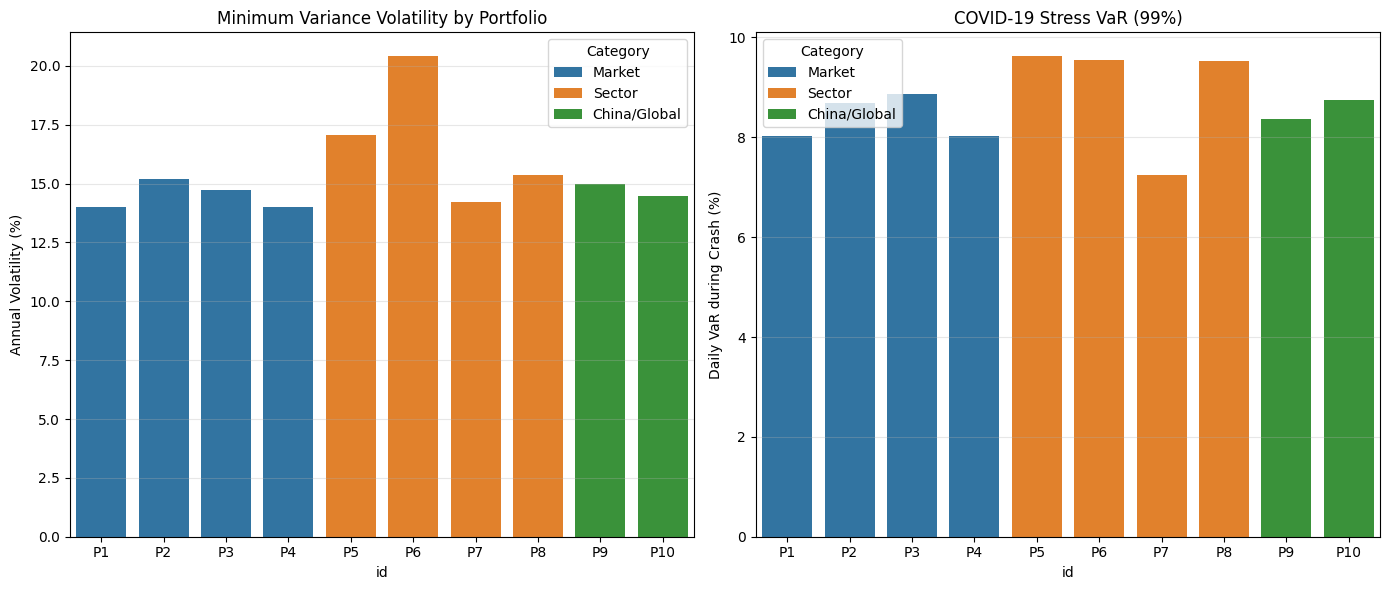

Results saved to data/comparison_final.csv


In [11]:
# Display Master Table
display_cols = ['id', 'Name', 'n_stocks', 'mv_vol', 'ew_vol', 'vol_reduction', 'current_ewma_vol', 'covid_var_99', 'eff_n']

print("### Master Comparison Table")
display(df_results[display_cols].style.background_gradient(subset=['mv_vol', 'covid_var_99'], cmap='RdYlGn_r'))

# Visualization
plt.figure(figsize=(14, 6))

# Plot 1: Volatility Comparison
plt.subplot(1, 2, 1)
sns.barplot(data=df_results, x='id', y='mv_vol', hue='Category', dodge=False)
plt.title('Minimum Variance Volatility by Portfolio')
plt.ylabel('Annual Volatility (%)')
plt.grid(axis='y', alpha=0.3)

# Plot 2: Crisis Robustness (COVID VaR)
plt.subplot(1, 2, 2)
sns.barplot(data=df_results, x='id', y='covid_var_99', hue='Category', dodge=False)
plt.title('COVID-19 Stress VaR (99%)')
plt.ylabel('Daily VaR during Crash (%)')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()

# Save Visualization
plt.savefig("data/comparison_charts.png")
print("Charts saved to data/comparison_charts.png")

plt.show()

# Save final results
df_results.to_csv("data/comparison_final.csv", index=False)
print("Results saved to data/comparison_final.csv")

In [12]:
# Generate Markdown Report
def generate_report(df):
    report = []
    report.append("# Multi-Portfolio Risk Analysis Report")
    report.append(f"Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}\n")
    
    report.append("## 1. Executive Summary")
    best_risk = df.loc[df['mv_vol'].idxmin()]
    worst_risk = df.loc[df['mv_vol'].idxmax()]
    best_div = df.loc[df['eff_n'].idxmax()]
    
    report.append(f"This analysis compared **{len(df)} different portfolio strategies** across Market, Sector, and Global themes.")
    report.append(f"- **Lowest Risk Strategy**: {best_risk['Name']} ({best_risk['mv_vol']:.2f}% Volatility)")
    report.append(f"- **Highest Risk Strategy**: {worst_risk['Name']} ({worst_risk['mv_vol']:.2f}% Volatility)")
    report.append(f"- **Most Diversified**: {best_div['Name']} (Effective N: {best_div['eff_n']:.1f})\n")
    
    report.append("## 2. Visualization")
    report.append("![Risk Comparison](comparison_charts.png)\n")
    
    report.append("## 3. detailed Metrics Table")
    # Format table
    table_str = df[['id', 'Name', 'mv_vol', 'ew_vol', 'vol_reduction', 'covid_var_99', 'eff_n']].to_markdown(index=False, floatfmt=".2f")
    report.append(table_str)
    
    report.append("\n## 4. Key Insights")
    report.append("### Volatility Reduction via Optimization")
    avg_reduction = df['vol_reduction'].mean()
    report.append(f"On average, Minimum Variance Optimization reduced portfolio volatility by **{avg_reduction:.1f}%** compared to an equal-weighted benchmark.")
    
    report.append("\n### Crisis Robustness (COVID-19)")
    report.append("The stress test simulates the February-March 2020 market crash. The 'COVID VaR' represents the worst daily loss at 99% confidence during that period.")
    
    with open("data/REPORT.md", "w") as f:
        f.write("\n".join(report))
    
    print("Report generated at data/REPORT.md")

generate_report(df_results)

Report generated at data/REPORT.md
